<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Action-Recognition/blob/main/Feature_Level_Fusion_(Prewitt%2B_acc%2B_gyro).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path_sensor = "drive/My Drive/Dataset/sensor_features_acc_gyro.mat"
gdrive_path_image = "drive/My Drive/Dataset/alexnet_features(Prewitt).mat"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn


In [11]:
img = sio.loadmat(gdrive_path_image)
sensor = sio.loadmat(gdrive_path_sensor)

In [12]:
X_train_img = img['X_train']
X_test_img = img['X_test']
X_train_sensor = sensor['X_train']
X_test_sensor = sensor['X_test']
y_train = img['y_train'].ravel()
y_test = img['y_test'].ravel()


In [13]:
X_train = np.column_stack((X_train_img, X_train_sensor))
X_test = np.column_stack((X_test_img, X_test_sensor))

In [14]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.hidden2 = nn.Linear(2048,1024)
        self.hidden3 = nn.Linear(1024,256)
        self.hidden4 = nn.Linear(256,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [15]:
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]


def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = MinMaxScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = 0.001
  num_epochs = 1001
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  best_lr = None
  best_loss = 100000
  best_model = None
  best_train_loss = None
  best_val_loss = None
  best_epoch = None
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
  for lr in [0.01]:
    #print(f"Learning rate: {lr}:")
    net = DNN(input_size, output_size)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
    cnt = 1
    figure, ax = plt.subplots(3,figsize=(10,10))
    for train_index, val_index in skf.split(X_train, y_train):
      train_X_fold = train_X[train_index]
      train_y_fold = train_y[train_index]
      val_x_fold = train_X[val_index]
      val_y_fold = train_y[val_index]
      n_samples = train_X_fold.shape[0]
      batch_size = int(n_samples/5)
      train_loss = []
      val_loss = []
      print(f"Training for fold {cnt}")
      for epoch in range(num_epochs):
        step = 1
        while(batch_size*step<=n_samples):
          x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
          # Forward Propagation
          y_predicted = net(x)
          loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
          # Backward propagation and update
          loss.backward()
          optimizer.step()
          # Performing zero grad before new step
          optimizer.zero_grad()
          step = step+1
        t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
        v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
        train_loss.append(t_loss) 
        val_loss.append(v_loss)
        if(v_loss<best_loss):
          best_lr = lr
          best_loss = v_loss
          best_model = net
          best_epoch = epoch
      m = "Fold "+str(cnt)
      ax[cnt-1].title.set_text(m)
      ax[cnt-1].set_ylabel("Total Loss")
      ax[cnt-1].set_xlabel("No of Epochs")
      ax[cnt-1].plot(range(1001),train_loss, label = "train loss")
      ax[cnt-1].plot(range(1001),val_loss, label = "validation loss")
      cnt+=1
  y_pred = best_model(test_X)
  print(best_loss)
  return best_model, y_pred


Training for fold 1
Training for fold 2
Training for fold 3
8.962634346032055e-06


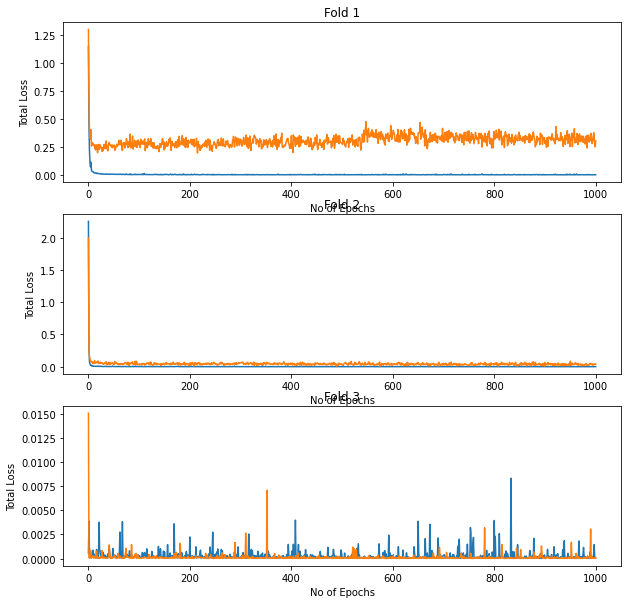

In [16]:
best_model, y_pred = model_training_evaluation(X_train, X_test, y_train, y_test)

In [24]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision

Accuracy: 98.57%
Precision: 98.68%
Recall: 98.58%


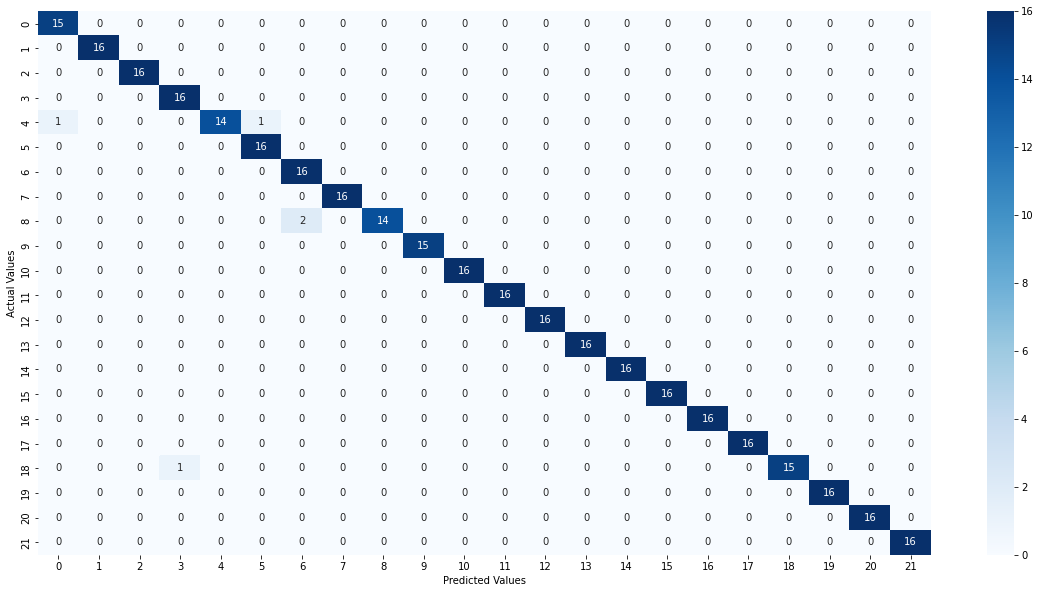

In [25]:
cm,acc, recall, precision = cf_matrix(y_pred, y_test)

In [22]:
model_save_name = 'feature_fusion_prewitt_sensor.pt'
path = F"/content/drive/My Drive/Dataset/Models/{model_save_name}" 
torch.save(best_model.state_dict(), path)